# Project idea

This project aims to develop an urban analytics tool to assess public transportation accessibility in two neighborhoods of Thessaloniki (Toumpa, Ano Poli). The primary focus is to calculate and analyze the walking accessibility to the nearest bus stop, comparing the two areas based on this metric.

## Data

The data used in this analysis was extracted from OpenStreetMap (OSM) using the OSMnx library, focusing on building footprints, street networks, and public transportation points.

In [1]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
OUTPUT_DIRECTORY = NOTEBOOK_PATH / "docs"

In [2]:
import pandas 
import geopandas
import shapely.geometry
import osmnx

### OSM Toumpa data

In [3]:
# Get data from OSM about toumpa
toumpa = "4η Κοινότητα Θεσσαλονίκης, Δημοτική Ενότητα Θεσαλονίκης, Δήμος Θεσσαλονίκης, Μητροπολιτική Ενότητα Θεσσαλονίκης, Περιφέρεια Κεντρικής Μακεδονίας, Αποκεντρωμένη Διοίκηση Μακεδονίας - Θράκης, Ελλάδα"

# Get the walking network
graph_walk_t = osmnx.graph_from_place(toumpa, network_type='walk')

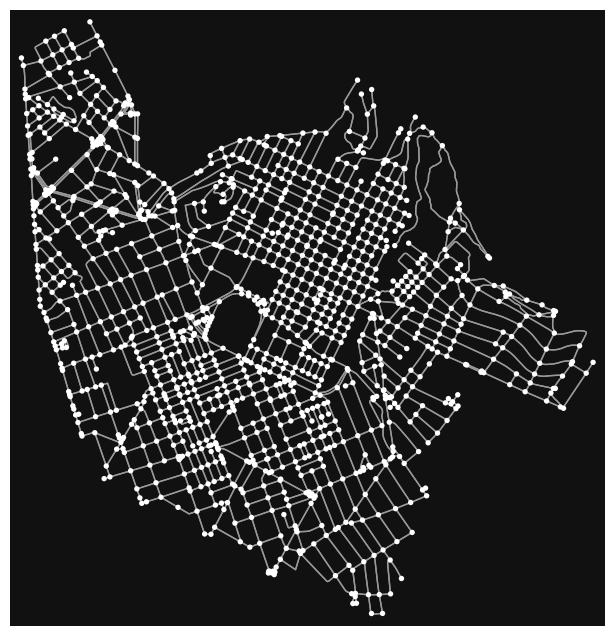

In [4]:
# Plot the graph to test
figure, ax = osmnx.plot_graph(graph_walk_t)

###  OSM Ano poli data

In [5]:
# Get data about ano poli
anopoli = "3η Κοινότητα Θεσσαλονίκης, Δημοτική Ενότητα Θεσαλονίκης, Δήμος Θεσσαλονίκης, Μητροπολιτική Ενότητα Θεσσαλονίκης, Περιφέρεια Κεντρικής Μακεδονίας, Αποκεντρωμένη Διοίκηση Μακεδονίας - Θράκης, Ελλάδα"

# Get the walking network
graph_walk_ano = osmnx.graph_from_place(anopoli, network_type='walk')

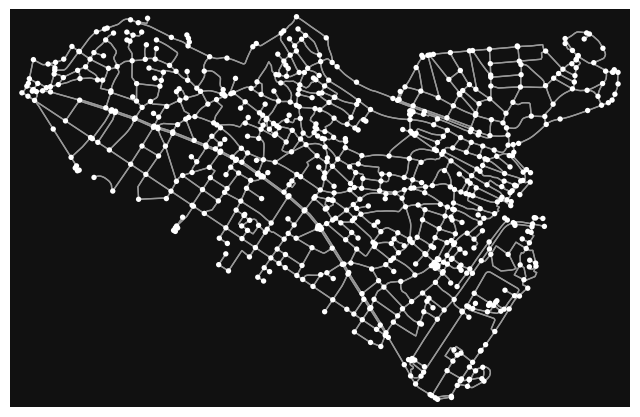

In [6]:
# Plot the graph to test
figure, ax = osmnx.plot_graph(graph_walk_ano)

## Public Transportation Accessibility

To analyze public transportation accessibility, we first extract the walking network for the selected neighborhoods using OpenStreetMap (OSM) data. This step involves retrieving pedestrian-friendly street networks, which form the basis for calculating walking distances to the nearest bus stops.

### Walking Network

#### Toumpa

In [7]:
# Seperate to edges and nodes
nodes_walk_t, edges_walk_t = osmnx.graph_to_gdfs(graph_walk_t)

# Get Area polygon
area_toumpa = osmnx.geocode_to_gdf(toumpa)

# Reproject the crs
area_toumpa = area_toumpa.to_crs(2100)
nodes_walk_t = nodes_walk_t.to_crs(2100)
edges_walk_t = edges_walk_t.to_crs(2100)
graph_walk_t = osmnx.project_graph(graph_walk_t, to_crs='EPSG:2100')

''' # Check the graph CRS
    graph_walk_t.graph["crs"] '''

' # Check the graph CRS\n    graph_walk_t.graph["crs"] '

#### Ano poli

In [8]:
# Seperate to edges and nodes
nodes_walk_ano, edges_walk_ano = osmnx.graph_to_gdfs(graph_walk_ano)

# Get Area polygon
area_anopoli = osmnx.geocode_to_gdf(anopoli)

# Reproject the crs
area_anopoli = area_anopoli.to_crs(2100)
nodes_walk_ano = nodes_walk_ano.to_crs(2100)
edges_walk_ano = edges_walk_ano.to_crs(2100)
graph_walk_ano = osmnx.project_graph(graph_walk_ano, to_crs='EPSG:2100')

### Prepare and Clean Building Data

To ensure accurate accessibility analysis, we process and clean the building footprint data extracted from OpenStreetMap (OSM). This step involves filtering, restructuring, and transforming the dataset to retain only relevant attributes and remove inconsistencies.

#### Toumpa

In [9]:
# Building Footprints
buildings_toumpa = osmnx.features_from_place(
    toumpa,
    {"building": True},
)

# Filter columns
buildings_toumpa = buildings_toumpa[["geometry", "building", "name", "addr:street", "addr:housenumber"]]

# Rename columns
buildings_toumpa = buildings_toumpa.rename(columns={"addr:street": "street", "addr:housenumber": "number" })

# Filter out Non Polygons
valid_geom_types = ["Polygon", "MultiPolygon"]
buildings_toumpa = buildings_toumpa[
    buildings_toumpa.geometry.type.isin(valid_geom_types)
]

# Convert the multi‐index to normal columns
buildings_toumpa = buildings_toumpa.reset_index()

# Make "id" the new (single‐level) index
buildings_toumpa = buildings_toumpa.set_index("id")

# Reproject the crs 
buildings_toumpa = buildings_toumpa.to_crs(2100)

# Get the centroid of the buildings
buildings_toumpa["centroid"] = buildings_toumpa.geometry.centroid

#### Ano poli

In [10]:
# Building Footprints
buildings_anopoli = osmnx.features_from_place(
    anopoli,
    {"building": True},
)

# Filter columns
buildings_anopoli = buildings_anopoli[["geometry", "building", "name", "addr:street", "addr:housenumber"]]

# Rename columns
buildings_anopoli = buildings_anopoli.rename(columns={"addr:street": "street", "addr:housenumber": "number" })

# Filter out Non Polygons
valid_geom_types = ["Polygon", "MultiPolygon"]
buildings_anopoli = buildings_anopoli[
    buildings_anopoli.geometry.type.isin(valid_geom_types)
]

# Convert the multi‐index to normal columns
buildings_anopoli = buildings_anopoli.reset_index()

# Make "id" the new (single‐level) index
buildings_anopoli = buildings_anopoli.set_index("id")

# Reproject the crs 
buildings_anopoli = buildings_anopoli.to_crs(2100)

# Get the centroid of the buildings
buildings_anopoli["centroid"] = buildings_anopoli.geometry.centroid

### Nearest node

This method is used because each building's centroid is efficiently snapped to the nearest node on the walking network, ensuring that network-based accessibility is calculated rather than relying on straight-line distances. It is preferred because the vectorized approach allows large datasets to be processed in an efficient manner.

#### Toumpa

In [11]:
# Extract x and y from the centroid column
buildings_toumpa["x_centroid"] = buildings_toumpa["centroid"].x
buildings_toumpa["y_centroid"] = buildings_toumpa["centroid"].y

# Find Nearest node
buildings_toumpa["nearest_node"] = osmnx.nearest_nodes(
    graph_walk_t, 
    X=buildings_toumpa["x_centroid"].values,
    Y=buildings_toumpa["y_centroid"].values
)

#### Ano poli

In [12]:
# Extract x and y from the centroid column
buildings_anopoli["x_centroid"] = buildings_anopoli["centroid"].x
buildings_anopoli["y_centroid"] = buildings_anopoli["centroid"].y

# Find Nearest node
buildings_anopoli["nearest_node"] = osmnx.nearest_nodes(
    graph_walk_ano, 
    X=buildings_anopoli["x_centroid"].values,
    Y=buildings_anopoli["y_centroid"].values
)

### Point of interest (POI) - Process bus stop data

In this step, bus stop data is first extracted from OSM and filtered so that only point features are retained. The data is then reprojected to EPSG:2100 so that all datasets are in the same coordinate system. Finally, each bus stop is snapped to the nearest node on the walking network using a vectorized method, ensuring that subsequent network-based distance calculations can be performed accurately.

#### Toumpa

In [13]:
# Get Bus stops
bus_toumpa = osmnx.features_from_place(
    toumpa,
    {
        "highway": "bus_stop"
    }
)

# Filter columns
bus_toumpa = bus_toumpa[["geometry", "name"]]

# Filter to retain only point features (bus stops are expected to be points)
bus_toumpa = bus_toumpa[bus_toumpa.geometry.type == "Point"]

# Reproject crs
bus_toumpa = bus_toumpa.to_crs(epsg=2100)

# Extract x and y coordinates from bus stop geometries
bus_toumpa["x"] = bus_toumpa.geometry.x
bus_toumpa["y"] = bus_toumpa.geometry.y

# Find Nearest node
bus_toumpa["nearest_node"] = osmnx.nearest_nodes(
    graph_walk_t,
    X=bus_toumpa["x"].values,
    Y=bus_toumpa["y"].values
)

In [14]:
# Check that the crs is the same on all data
buildings_toumpa.crs == graph_walk_t.graph["crs"] == nodes_walk_t.crs == edges_walk_t.crs == bus_toumpa.crs == area_toumpa.crs

True

#### Ano poli

In [15]:
# Get Bus stops
bus_anopoli = osmnx.features_from_place(
    anopoli,
    {
        "highway": "bus_stop"
    }
)

# Filter columns
bus_anopoli = bus_anopoli[["geometry", "name"]]

# Filter to retain only point features (bus stops are expected to be points)
bus_anopoli = bus_anopoli[bus_anopoli.geometry.type == "Point"]

# Reproject crs
bus_anopoli = bus_anopoli.to_crs(epsg=2100)

# Extract x and y coordinates from bus stop geometries
bus_anopoli["x"] = bus_anopoli.geometry.x
bus_anopoli["y"] = bus_anopoli.geometry.y

# Find Nearest node
bus_anopoli["nearest_node"] = osmnx.nearest_nodes(
    graph_walk_ano,
    X=bus_anopoli["x"].values,
    Y=bus_anopoli["y"].values
)

In [16]:
# Check that the crs is the same on all data
buildings_anopoli.crs == graph_walk_ano.graph["crs"] == nodes_walk_ano.crs == edges_walk_ano.crs == bus_anopoli.crs == area_anopoli.crs

True

### Shortest Path Walking Distance

For each building’s centroid, the Euclidean distances to all bus stops are calculated, and the smallest (closest) distance is identified. For simplicity, only the straight‐line distance is used, rather than the full walking path distance.

#### Toumpa

In [17]:
buildings_toumpa["distance_to_busstop"] = buildings_toumpa["centroid"].geometry.apply(
    lambda x: bus_toumpa.distance(x).min().round(2)
)

For each centroid, the name and node ID of the closest bus stop are retrieved and stored in the respective columns.

In [18]:
buildings_toumpa["bus_stop"] = buildings_toumpa["centroid"].geometry.apply(
    lambda x: bus_toumpa.loc[bus_toumpa.geometry.distance(x).idxmin()]["name"]
)

buildings_toumpa["bus_node"] = buildings_toumpa["centroid"].geometry.apply(
    lambda x: bus_toumpa.loc[bus_toumpa.geometry.distance(x).idxmin()]["nearest_node"]
)

A list of dictionaries, each representing a route, is built. The start and end node IDs for each building are used with OSMnx to compute the shortest path, and if a valid route is found, its geometry is converted into a LineString; otherwise, an empty LineString is assigned. All route information is then compiled into a GeoDataFrame, ensuring a row is created for every building.

In [19]:
# We'll accumulate a list of dicts, each representing one route row
all_routes = []

# Loop through each building
for idx, row in buildings_toumpa.iterrows():
    start_node = row["nearest_node"]
    end_node = row["bus_node"]

    # Compute the shortest path
    route = osmnx.shortest_path(graph_walk_t, start_node, end_node)
    
    # If no route or only a single node, make an empty LineString
    if route is None or len(route) < 2:
        route_line = shapely.geometry.LineString([])
        route_length = 0.0
        # Store an empty list if no valid route
        route_nodes_list = route if route else []
    else:
        # Grab the corresponding geometry from nodes for each node in route
        route_nodes = nodes_walk_t.loc[route]
        route_line = shapely.geometry.LineString(route_nodes.geometry.values)
        route_length = route_line.length
        route_nodes_list = route
    
    # Build our dictionary of attributes for this row
    route_info = {
        "geometry": route_line,
        "osm_nodes": route_nodes_list,
        "building_id": idx,
        "walking_distance_m": round(route_length, 2),
    }
    
    # Append the dictionary to our list
    all_routes.append(route_info)

# Convert to a GeoDataFrame
all_routes_gdf = geopandas.GeoDataFrame(all_routes, crs=edges_walk_t.crs)

# all_routes_gdf now has a row for each building:
#  - If a route was found with ≥2 nodes, you'll see a proper LineString.
#  - If not, it's an empty LineString (distance = 0).
all_routes_gdf.head()


,geometry,osm_nodes,building_id,walking_distance_m
0,"LINESTRING (412991.909 4496051.588, 412979.505...","[1746366364, 147139132, 147139036, 9405249416,...",1626844,181.87
1,"LINESTRING (412429.717 4496017.223, 412460.914...","[137297495, 1285545462, 147080866, 187402116, ...",13081291,143.89
2,"LINESTRING (413563.18 4496477.07, 413578.337 4...","[208624855, 208633344, 147137707, 734082307, 1...",13109701,357.24
3,"LINESTRING (412239.661 4496958.496, 412232.513...","[11568612656, 1741653592, 2231961713, 137197112]",17126327,54.01
4,"LINESTRING (412207.536 4496780.652, 412133.464...","[12396240044, 12396240048, 1457129544, 1462001...",14793102,282.56


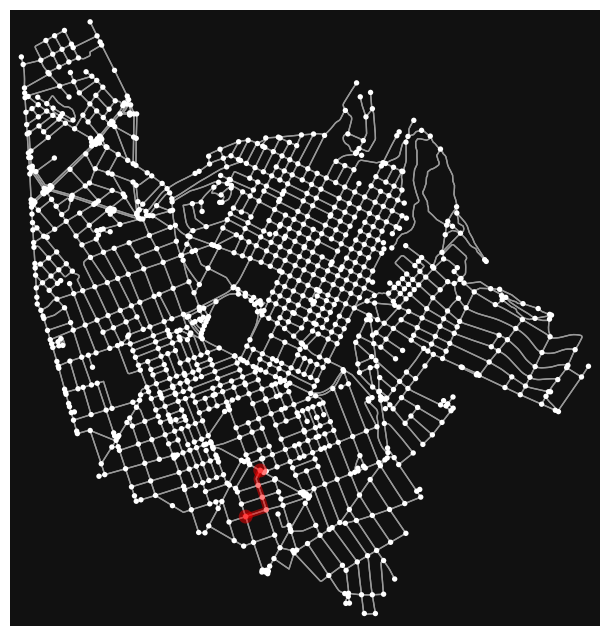

In [20]:
# Visualization Test
fig, ax = osmnx.plot_graph_route(graph_walk_t, all_routes_gdf["osm_nodes"].iloc[19])

#### Ano poli

In [21]:
buildings_anopoli["distance_to_busstop"] = buildings_anopoli["centroid"].geometry.apply(
    lambda x: bus_anopoli.distance(x).min().round(2)
)

buildings_anopoli["bus_stop"] = buildings_anopoli["centroid"].geometry.apply(
    lambda x: bus_anopoli.loc[bus_anopoli.geometry.distance(x).idxmin()]["name"]
)

buildings_anopoli["bus_node"] = buildings_anopoli["centroid"].geometry.apply(
    lambda x: bus_anopoli.loc[bus_anopoli.geometry.distance(x).idxmin()]["nearest_node"]
)

# We'll accumulate a list of dicts, each representing one route row
all_routes = []

# Loop through each building
for idx, row in buildings_anopoli.iterrows():
    start_node = row["nearest_node"]
    end_node = row["bus_node"]

    # Compute the shortest path
    route = osmnx.shortest_path(graph_walk_ano, start_node, end_node)
    
    # If no route or only a single node, make an empty LineString
    if route is None or len(route) < 2:
        route_line = shapely.geometry.LineString([])
        route_length = 0.0
        # Store an empty list if no valid route
        route_nodes_list = route if route else []
    else:
        # Grab the corresponding geometry from nodes for each node in route
        route_nodes = nodes_walk_ano.loc[route]
        route_line = shapely.geometry.LineString(route_nodes.geometry.values)
        route_length = route_line.length
        route_nodes_list = route
    
    # Build our dictionary of attributes for this row
    route_info = {
        "geometry": route_line,
        "osm_nodes": route_nodes_list,
        "building_id": idx,
        "walking_distance_m": round(route_length, 2),
    }
    
    # Append the dictionary to our list
    all_routes.append(route_info)

# Convert to a GeoDataFrame
all_routes_ano = geopandas.GeoDataFrame(all_routes, crs=edges_walk_ano.crs)

# all_routes_gdf now has a row for each building:
#  - If a route was found with ≥2 nodes, you'll see a proper LineString.
#  - If not, it's an empty LineString (distance = 0).
all_routes_ano.head()


,geometry,osm_nodes,building_id,walking_distance_m
0,"LINESTRING (411826.73 4498742.909, 411856.53 4...","[1745325843, 1260045483, 5434297241, 126004553...",2174723,443.53
1,"LINESTRING (412024.138 4499524.433, 412046.598...","[8150855463, 9464975455, 8150855474, 185004468...",5702419,279.10
2,"LINESTRING (412024.138 4499524.433, 412046.598...","[8150855463, 9464975455, 8150855474, 185004468...",5702422,279.10
3,"LINESTRING (412149.495 4499421.535, 412139.552...","[8483353670, 2614490098, 2614490094, 2614490096]",5702425,111.92
4,"LINESTRING (412091.557 4499541.134, 412100.33 ...","[8150855483, 8150855457, 8150855468, 185004468...",5702427,281.34


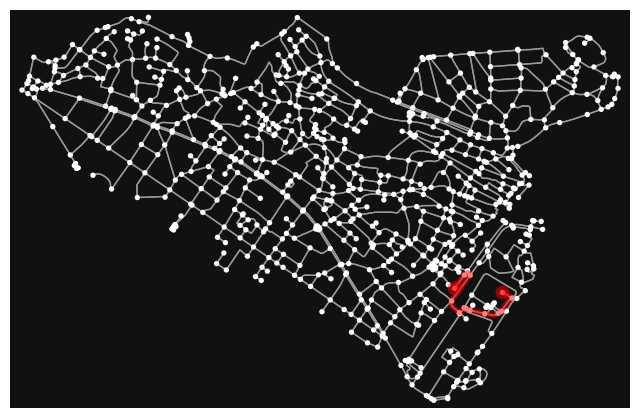

In [22]:
# Visualization Test
fig, ax = osmnx.plot_graph_route(graph_walk_ano, all_routes_ano["osm_nodes"].iloc[0])

### Calculate walking time

According to Browning et al. (2006), it has been observed that many people tend to walk at about 1.42 m/s. Consequently, the route distance was divided by this speed to compute the walking time in seconds, which was then converted to minutes.

#### Toumpa

In [23]:
# Merge the walking distances back to the buildings
buildings_toumpa = buildings_toumpa.merge(
    all_routes_gdf[["building_id", "walking_distance_m"]],
    how="left",
    left_index=True,  # Column in buildings_toumpa
    right_on="building_id"    # Column in all_routes_gdf
)

# Calculate walking time
buildings_toumpa["walking_time_min"] = (
    buildings_toumpa["walking_distance_m"] / 1.42 / 60
).round(2)

#### Ano poli

In [24]:
# Merge the walking distances back to the buildings
buildings_anopoli = buildings_anopoli.merge(
    all_routes_ano[["building_id", "walking_distance_m"]],
    how="left",
    left_index=True,  # Column in buildings_anopoli
    right_on="building_id"    # Column in all_routes_gdf
)

# Calculate walking time
buildings_anopoli["walking_time_min"] = (
    buildings_anopoli["walking_distance_m"] / 1.42 / 60
).round(2)

## Mapping

### Static Map

#### Toumpa

In [25]:
# Change the crs for the basemap
buildings_toumpa = buildings_toumpa.to_crs("EPSG:3857")
bus_toumpa = bus_toumpa.to_crs("EPSG:3857")
area_toumpa = area_toumpa.to_crs("EPSG:3857")
edges_walk_t = edges_walk_t.to_crs("EPSG:3857")

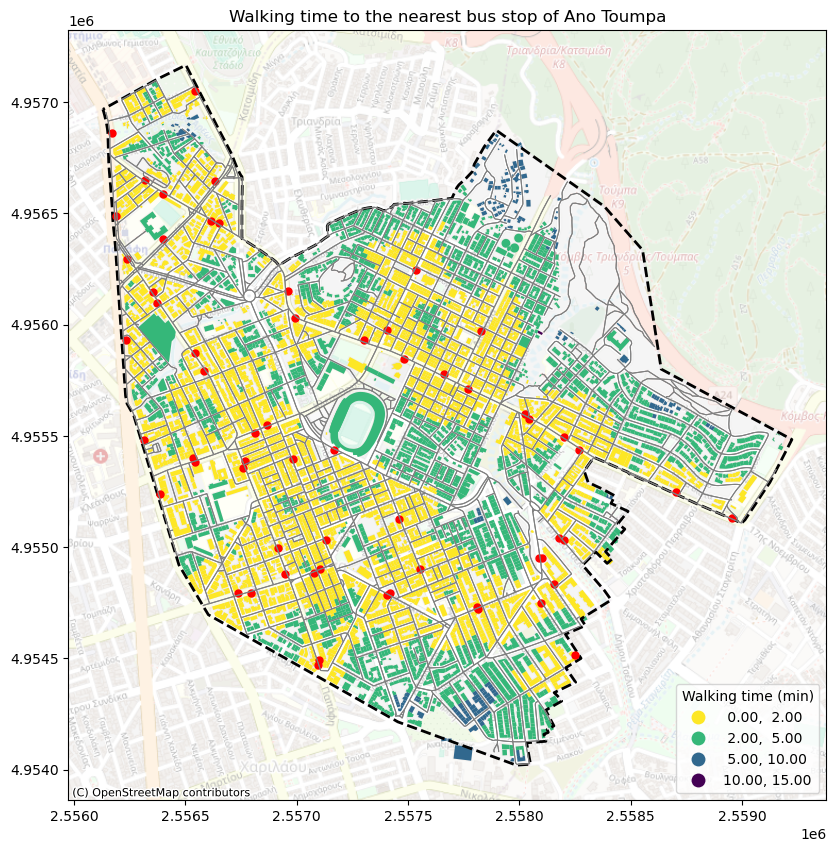

In [26]:
import matplotlib.pyplot as plt
import contextily
from mapclassify import UserDefined
import matplotlib.patches as mpatches

# Define custom breakpoints
breaks = [2, 5, 10, 15]

# Plot the data
ax = buildings_toumpa.plot(
    figsize=(10, 10),
    column="walking_time_min",
    scheme="UserDefined", # Classification 
    classification_kwds={"bins": breaks}, # Classification breaks
    legend=True,
    cmap=plt.cm.viridis.reversed(),
    legend_kwds={"title": "Walking time (min)", "loc": "lower right"},
)

area_toumpa.plot(
    ax=ax, 
    color="none", 
    edgecolor="black", 
    linewidth=2,
    linestyle='--',
)

edges_walk_t.plot(
    ax=ax,
    color="gray",
    linewidth=0.75
)

bus_toumpa.plot(
    ax=ax,
    color="red",
    markersize=25   
)

ax.set_title('Walking time to the nearest bus stop of Ano Toumpa')


# Add the basemap
contextily.add_basemap(ax, source = contextily.providers.OpenStreetMap.Mapnik, alpha=0.3)

plt.show()

#### Ano poli

In [27]:
# Change the crs for the basemap
buildings_anopoli = buildings_anopoli.to_crs("EPSG:3857")
bus_anopoli = bus_anopoli.to_crs("EPSG:3857")
area_anopoli = area_anopoli.to_crs("EPSG:3857")
edges_walk_ano = edges_walk_ano.to_crs("EPSG:3857")

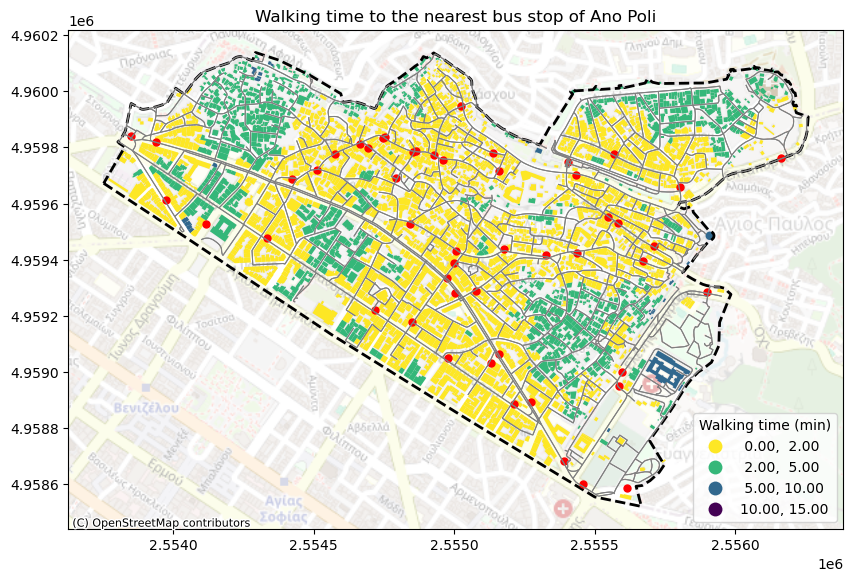

In [28]:
import matplotlib.pyplot as plt
import contextily
from mapclassify import UserDefined
import matplotlib.patches as mpatches

# Define custom breakpoints
breaks = [2, 5, 10, 15]

# Plot the data
ax = buildings_anopoli.plot(
    figsize=(10, 10),
    column="walking_time_min",
    scheme="UserDefined", # Classification 
    classification_kwds={"bins": breaks}, # Classification breaks
    legend=True,
    cmap=plt.cm.viridis.reversed(),
    legend_kwds={"title": "Walking time (min)", "loc": "lower right"},
)

area_anopoli.plot(
    ax=ax, 
    color="none", 
    edgecolor="black", 
    linewidth=2,
    linestyle='--',
)

edges_walk_ano.plot(
    ax=ax,
    color="gray",
    linewidth=0.75
)

bus_anopoli.plot(
    ax=ax,
    color="red",
    markersize=25   
)

ax.set_title('Walking time to the nearest bus stop of Ano Poli')


# Add the basemap
contextily.add_basemap(ax, source = contextily.providers.OpenStreetMap.Mapnik, alpha=0.3)

plt.show()

### Save Static Map data

To ensure compatibility with QGIS, all spatial data must be saved in the EPSG:2100 (Hellenic Geodetic Reference System). Since the data was reprojected to EPSG:3857 (Web Mercator) for visualization in Matplotlib, it must be reprojected back to EPSG:2100 before exporting.

#### Toumpa

In [29]:
# Change the crs for the GIS
buildings_toumpa = buildings_toumpa.to_crs("EPSG:2100")
bus_toumpa = bus_toumpa.to_crs("EPSG:2100")
area_toumpa = area_toumpa.to_crs("EPSG:2100")
edges_walk_t = edges_walk_t.to_crs("EPSG:2100")
all_routes_gdf = all_routes_gdf.to_crs("EPSG:2100")

In [30]:
# Drop centroid columns
buildings_toumpa = buildings_toumpa.drop(columns=["centroid", "x_centroid", "y_centroid"], axis=1)

In [31]:
# Ensure the output directory exists
OUTPUT_DIRECTORY.mkdir(parents=True, exist_ok=True)

# Save one layer after another as Geopackage
output_gpkg = OUTPUT_DIRECTORY / "toumpa_accessibility.gpkg"

buildings_toumpa.to_file(output_gpkg, layer="buildings", driver="GPKG")
bus_toumpa.to_file(output_gpkg, layer="bus_stops", driver="GPKG")
area_toumpa.to_file(output_gpkg, layer="area", driver="GPKG")
edges_walk_t.to_file(output_gpkg, layer="walking_network", driver="GPKG")
all_routes_gdf.to_file(output_gpkg, layer="walking_routes", driver="GPKG")

#### Ano poli

In [32]:
# Change the crs for the GIS
buildings_anopoli = buildings_anopoli.to_crs("EPSG:2100")
bus_anopoli = bus_anopoli.to_crs("EPSG:2100")
area_anopoli = area_anopoli.to_crs("EPSG:2100")
edges_walk_ano = edges_walk_ano.to_crs("EPSG:2100")
all_routes_ano = all_routes_ano.to_crs("EPSG:2100")

In [33]:
# Drop centroid columns
buildings_anopoli = buildings_anopoli.drop(columns=["centroid", "x_centroid", "y_centroid"], axis=1)

In [34]:
# Save one layer after another as Geopackage
output_gpkg = OUTPUT_DIRECTORY / "anopoli_accessibility.gpkg"

buildings_anopoli.to_file(output_gpkg, layer="buildings", driver="GPKG")
bus_anopoli.to_file(output_gpkg, layer="bus_stops", driver="GPKG")
area_anopoli.to_file(output_gpkg, layer="area", driver="GPKG")
edges_walk_ano.to_file(output_gpkg, layer="walking_network", driver="GPKG")
all_routes_ano.to_file(output_gpkg, layer="walking_routes", driver="GPKG")

### Folium Interactive Map

The Folium interactive maps experienced heavy loading times due to the full dataset being embedded in the HTML. By offloading data storage and distribution to a dedicated backend, the map now loads only the necessary data dynamically, greatly enhancing performance and scalability.

#### Backend Architecture 


To improve performance and scalability, the following components were integrated into the new backend solution:

- **Cloud Server**: Hosts the entire backend stack.

- **Docker**: Containerization platform for managing services.

- **PostGIS**: PostgreSQL extension used for spatial data storage.

- **GDAL** (ogr2ogr): Used to ingest and upload geospatial data into the PostGIS database.

- **GeoServer**: Distributes data using OGC standards (WMS, WFS) to the Folium map.

*Bus Stop Data (HTML + MarkerCluster):* For bus stop data, we load it directly from the HTML to take advantage of the Folium MarkerCluster plugin, which efficiently handles large numbers of point features.


#### Toumpa

In [35]:
# Get attribute data from buildings layer as GeoJSON using WFS
wfs_buildingst = (
    "https://thanosgis.me/geoserver/wfs?"
    "service=WFS&version=2.0.0&request=GetFeature&"
    "typeName=project1:buildings_toumpa&srsName=EPSG:4326&outputFormat=application/json" #specify the crs "srsName=EPSG:4326"
)

# Change the crs for the interactive map
bus_toumpa = bus_toumpa.to_crs("EPSG:4326")

# Extract x and y coordinates from bus stop geometries for markers
bus_toumpa["x"] = bus_toumpa.geometry.x
bus_toumpa["y"] = bus_toumpa.geometry.y


In [41]:
wfs_buildingst = (
    "http://157.230.18.139:8080/geoserver/wfs?"
    "service=WFS&version=2.0.0&request=GetFeature&"
    "typeName=project1:buildings_toumpa&srsName=EPSG:4326&outputFormat=application/json" #specify the crs "srsName=EPSG:4326"
)

In [ ]:
import folium
import folium.features
from folium.plugins import MarkerCluster, Fullscreen
from branca.element import MacroElement, Template

# Create a folium map with no default basemap
m = folium.Map(
    location=[40.618, 22.975],
    zoom_start=14,
    tiles=None  # We'll add our own basemap below
)

# Add the CartoDB Positron tile layer (default on)
folium.TileLayer(
    'CartoDB positron',
    name='CartoDB Positron',
    control=True,
    show=True  # Show this layer by default
).add_to(m)

# Add the OpenStreetMap tile layer (off by default)
folium.TileLayer(
    'OpenStreetMap',
    name='OpenStreetMap',
    control=True,
    show=False  # Do not show this layer by default
).add_to(m)

# Custom legend
# Load your custom HTML from the file
with open("my_legend.html", "r") as f:
     legend_html = f.read()
# Create a MacroElement from that HTML
legend = MacroElement()
legend._template = Template(legend_html)
# Attach the legend to the map
m.add_child(legend)

# Buildings WMS layer
folium.WmsTileLayer(
    url="http://157.230.18.139:8080/geoserver/wms",  # workspace-level endpoint
    name="Buildings Toumpa (WMS)",
    layers="project1:buildings_toumpa",  # exactly as it appears in GetCapabilities
    styles="",                           # empty if using the default style
    fmt="image/png",
    transparent=True,
    version="1.1.1",
    maxZoom=20, # zoom level where the wms layer is visible
).add_to(m)

# Tooltip for buildings
tooltip = folium.GeoJsonTooltip(
    fields=["building_id", "bus_stop", "walking_distance_m", "walking_time_min"],
    aliases=["building_id", "nearest_bus_stop", "walking_distance_m", "walking_time_min"],
)

def style_function(feature): # Make the tooltip transparent
    return {
        "color": "transparent",
        "fillColor": "transparent"
    }

tooltip_layer = folium.GeoJson(
    wfs_buildingst,
    style_function=style_function,
    tooltip=tooltip,
    name="Attributes"
).add_to(m)

# Toumpa WMS area layer
folium.WmsTileLayer(
    url="http://157.230.18.139:8080/geoserver/wms",  # workspace-level endpoint
    name="Area of Toumpa (WMS)",
    layers="project1:area_toumpa",
    styles="",                           
    fmt="image/png",
    transparent=True,
    version="1.1.1",
    maxZoom=20, 
).add_to(m)

# Walking Network WMS area layer
folium.WmsTileLayer(
    url="http://157.230.18.139:8080/geoserver/wms",  
    name="Walking network (WMS)",
    layers="project1:walking_network_toumpa", 
    styles="",                           
    fmt="image/png",
    transparent=True,
    version="1.1.1",
    maxZoom=20, 
).add_to(m)

# Create a MarkerCluster for bus stops
marker_cluster = MarkerCluster(name='Bus Stops').add_to(m)

# Add bus stop markers to the cluster
for index, row in bus_toumpa.iterrows():
    popup_text = f"<strong>Bus stop:</strong> {row['name']}"
    popup = folium.Popup(popup_text, max_width=250)

    folium.Marker(
        [row["y"], row["x"]],
        popup=popup,
        tooltip="Click for bus stop info",
        icon=folium.Icon(color="red", prefix='fa', icon='bus')
    ).add_to(marker_cluster)

# Add a fullscreen button
Fullscreen().add_to(m)

# Add a layer control so we can toggle layers on/off
folium.LayerControl().add_to(m)

# Display map
m


In [51]:
import folium
import folium.features
from folium import JsCode
from folium.plugins import MarkerCluster, Fullscreen, Realtime
from branca.element import MacroElement, Template

# Create a folium map with no default basemap
m = folium.Map(
    location=[40.618, 22.975],
    zoom_start=14,
    tiles=None  # We'll add our own basemap below
)

# Add the CartoDB Positron tile layer (default on)
folium.TileLayer(
    'CartoDB positron',
    name='CartoDB Positron',
    control=True,
    show=True  # Show this layer by default
).add_to(m)

# Add the OpenStreetMap tile layer (off by default)
folium.TileLayer(
    'OpenStreetMap',
    name='OpenStreetMap',
    control=True,
    show=False  # Do not show this layer by default
).add_to(m)

# Custom legend
# Load your custom HTML from the file
with open("my_legend.html", "r") as f:
     legend_html = f.read()
# Create a MacroElement from that HTML
legend = MacroElement()
legend._template = Template(legend_html)
# Attach the legend to the map
m.add_child(legend)

# Buildings WMS layer
folium.WmsTileLayer(
    url="http://157.230.18.139:8080/geoserver/wms",  # workspace-level endpoint
    name="Buildings Toumpa (WMS)",
    layers="project1:buildings_toumpa",  # exactly as it appears in GetCapabilities
    styles="",                           # empty if using the default style
    fmt="image/png",
    transparent=True,
    version="1.1.1",
    maxZoom=20, # zoom level where the wms layer is visible
).add_to(m)

# Toumpa WMS area layer
folium.WmsTileLayer(
    url="http://157.230.18.139:8080/geoserver/wms",  # workspace-level endpoint
    name="Area of Toumpa (WMS)",
    layers="project1:area_toumpa",
    styles="",                           
    fmt="image/png",
    transparent=True,
    version="1.1.1",
    maxZoom=20, 
).add_to(m)

# Walking Network WMS area layer
folium.WmsTileLayer(
    url="http://157.230.18.139:8080/geoserver/wms",  
    name="Walking network (WMS)",
    layers="project1:walking_network_toumpa", 
    styles="",                           
    fmt="image/png",
    transparent=True,
    version="1.1.1",
    maxZoom=20, 
).add_to(m)

# Create a MarkerCluster for bus stops
marker_cluster = MarkerCluster(name='Bus Stops').add_to(m)

# Add bus stop markers to the cluster
for index, row in bus_toumpa.iterrows():
    popup_text = f"<strong>Bus stop:</strong> {row['name']}"
    popup = folium.Popup(popup_text, max_width=250)

    folium.Marker(
        [row["y"], row["x"]],
        popup=popup,
        tooltip="Click for bus stop info",
        icon=folium.Icon(color="red", prefix='fa', icon='bus')
    ).add_to(marker_cluster)

# Custom javascript for tooltip
tooltip_js = JsCode("""
function onEachFeature(feature, layer) {
    if (feature.properties) {
        // Build an HTML string with inline CSS
        var content = '<div style="font-size:12px; color:#333;">' +
                      '<strong>Building ID:</strong> ' + feature.properties.building_id + '<br>' +
                      '<strong>Nearest Bus Stop:</strong> ' + feature.properties.bus_stop + '<br>' +
                      '<strong>Walking Distance (m):</strong> ' + feature.properties.walking_distance_m + '<br>' +
                      '<strong>Walking Time (min):</strong> ' + feature.properties.walking_time_min +
                      '</div>';

        layer.bindTooltip(content); // bindPopup for popup
    }
}
""")

# Custom javascript for style
style_js  = JsCode("""
function(feature) {
    return {
        color: 'transparent',     // No polygon outline
        fillColor: 'transparent', // No polygon fill
        weight: 0,               // Zero line weight
        fillOpacity: 0           // Fully transparent fill
    };
}
""")

wfs_buildingst = (
    "http://157.230.18.139:8080/geoserver/wfs?"
    "service=WFS&version=2.0.0&request=GetFeature&"
    "typeName=project1:buildings_toumpa&srsName=EPSG:4326&outputFormat=application/json" #specify the crs "srsName=EPSG:4326"
)

# Create the Realtime layer to poll the WFS endpoint
rt = Realtime(
    wfs_buildingst,
    get_feature_id=JsCode("(f) => { return f.properties.building_id; }"),
    style=style_js ,      # Apply the transparent style
    on_each_feature=tooltip_js,   # Bind the tooltip
    interval=10000,                      # Poll every 10 seconds
)

# Do not add Realtime directly to the map because it adds an extra layer on the ;ayer control
fg = folium.FeatureGroup(name="Attributes (WFS)").add_to(m)
fg.add_child(rt)

# Add a fullscreen button
Fullscreen().add_to(m)

# Add a layer control so we can toggle layers on/off
folium.LayerControl().add_to(m)

# Display map
m

#### Ano poli

In [ ]:
# Get attribute data from buildings layer as GeoJSON using WFS
wfs_buildingsa = (
    "https://thanosgis.me/geoserver/wfs?"
    "service=WFS&version=2.0.0&request=GetFeature&"
    "typeName=project1:buildings_anopoli&srsName=EPSG:4326&outputFormat=application/json" #specify the crs "srsName=EPSG:4326"
)

# Change the crs for the interactive map
bus_anopoli = bus_anopoli.to_crs("EPSG:4326")

# Extract x and y coordinates from bus stop geometries for markers
bus_anopoli["x"] = bus_anopoli.geometry.x
bus_anopoli["y"] = bus_anopoli.geometry.y

In [ ]:
# Create a folium map
m2 = folium.Map(
    location = (40.640978,22.9534333),
    zoom_start = 15,
    control_scale = True,
    tiles=None
)

# Add the base tile layers first
carto_map = folium.TileLayer(
    'CartoDB positron',
    name='CartoDB Positron',
    control=True,
    show=True  # This one shows by default
).add_to(m2)

open_street_map = folium.TileLayer(
    'OpenStreetMap',
    name='OpenStreetMap',
    control=True,
    show=False  # Off by default
).add_to(m2)

# Custom legend
# Load your custom HTML from the file
with open("my_legend.html", "r") as f:
     legend_html = f.read()
# Create a MacroElement from that HTML
legend = MacroElement()
legend._template = Template(legend_html)
# Attach the legend to the map
m2.add_child(legend)

# Buildings WMS layer
folium.WmsTileLayer(
    url="https://thanosgis.me/geoserver/wms",  # workspace-level endpoint
    name="Buildings Anopoli (WMS)",
    layers="project1:buildings_anopoli",  # exactly as it appears in GetCapabilities
    styles="",                           # empty if using the default style
    fmt="image/png",
    transparent=True,
    version="1.1.1",
    maxZoom=20, # zoom level where the wms layer is visible
).add_to(m2)

# Add a tooltip to display information about the buildings
tooltipa = folium.features.GeoJsonTooltip(
 fields=[
        "building_id",
        "bus_stop",
        "walking_distance_m",
        "walking_time_min"
    ], 
    aliases=[
        "building_id",
        "nearest_bus_stop",
        "walking_distance_m",
        "walking_time_min"
    ], 
)

def style_function(feature):
    return {
        "color": "transparent",
        "fillColor": "transparent"
    }

tooltipa_layer = folium.features.GeoJson(
    wfs_buildingsa,
    style_function=style_function,
    tooltip=tooltipa,
    name="Attributes"
).add_to(m2)

# Anopoli WMS area layer
folium.WmsTileLayer(
    url="https://thanosgis.me/geoserver/wms",  # workspace-level endpoint
    name="Area of Anopoli (WMS)",
    layers="project1:area_anopoli",
    styles="",                           
    fmt="image/png",
    transparent=True,
    version="1.1.1",
    maxZoom=20, 
).add_to(m2)

# Walking Network WMS area layer
folium.WmsTileLayer(
    url="https://thanosgis.me/geoserver/wms",  
    name="Walking network (WMS)",
    layers="project1:walking_network_anopoli", 
    styles="",                           
    fmt="image/png",
    transparent=True,
    version="1.1.1",
    maxZoom=20, 
).add_to(m2)

# Create a MarkerCluster for bus stops and add markers
marker_clustera = MarkerCluster(name='Bus Stops').add_to(m2)
for index, row in bus_anopoli.iterrows():
    # Format the popup content for each bus stop
    popup_texta = f"<strong>Bus stop:</strong> {row['name']}"
    popupa = folium.Popup(popup_texta, max_width=250)
    
    # Add a marker to the feature group
    folium.Marker(
        [row["y"], row["x"]],
        popup=popupa,
        tooltip="Click for bus stop info",
        icon=folium.Icon(color="red", prefix='fa', icon='bus')
    ).add_to(marker_clustera)

# Add a fullscreen button and layer control
Fullscreen().add_to(m2)
folium.LayerControl().add_to(m2)


m2

### Save Interactive Maps

In [ ]:
# Ensure the output directory exists
OUTPUT_DIRECTORY.mkdir(parents=True, exist_ok=True)

# Save the maps as html
m.save(OUTPUT_DIRECTORY / "toumpa_interactive.html")
m2.save(OUTPUT_DIRECTORY / "anopoli_interactive.html")